In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

# from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

/var/folders/q5/28w4wpqn1jl35m2zwwmqqxq40000gn/T/ipykernel_39463/3861184371.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 2. Load data

In [2]:
df_nflx = pd.read_csv('NFLX_close_sentiment.csv')
df_nflx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Close      1258 non-null   float64
 2   Sentiment  1258 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.6+ KB


In [3]:
df_nflx=df_nflx[['Close']]
df_nflx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1258 non-null   float64
dtypes: float64(1)
memory usage: 10.0 KB


In [4]:
df_nflx=df_nflx.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(0, 1))

df_nflx['Close'] = scaler.fit_transform(df_nflx['Close'].values.reshape(-1,1))

In [5]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test, test_set_size]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test, test_size = load_data(df_nflx, look_back)
print('x_train.shape = ',x_train.shape ,x_train.ndim)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (958, 59, 1) 3
y_train.shape =  (958, 1)
x_test.shape =  (240, 59, 1)
y_test.shape =  (240, 1)


In [6]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## 3. Build the structure of model

In [7]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [8]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.037332408130168915
Epoch  20 MSE:  0.007670409511774778
Epoch  30 MSE:  0.0031740048434585333
Epoch  40 MSE:  0.0019317755941301584
Epoch  50 MSE:  0.0015844200970605016
Epoch  60 MSE:  0.0014063747366890311
Epoch  70 MSE:  0.0012748762965202332
Epoch  80 MSE:  0.0011809826828539371
Epoch  90 MSE:  0.001116628642193973


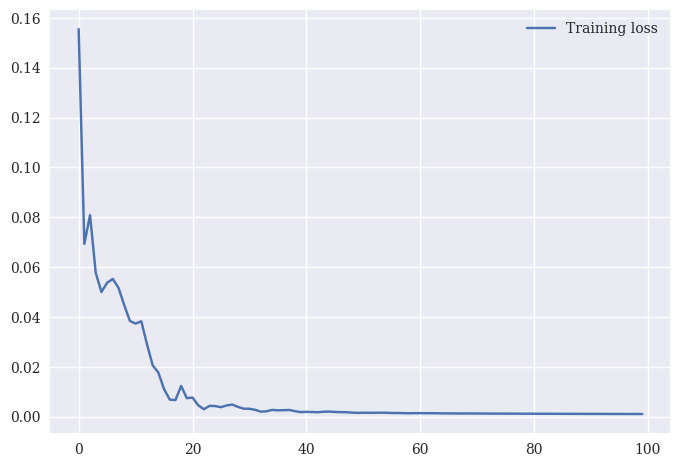

In [9]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [10]:
results = np.array([])

In [11]:
target_shape = (1, seq_dim, 1)
for i in range(test_size):
    reshaped_tensor = x_test[i].view(target_shape)
    with torch.no_grad():
        y_test_pred = model(reshaped_tensor)
        
    y_test_pred = y_test_pred.detach().numpy()
    results = np.append(results, y_test_pred)

In [12]:
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
results = scaler.inverse_transform(results.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.detach().numpy())

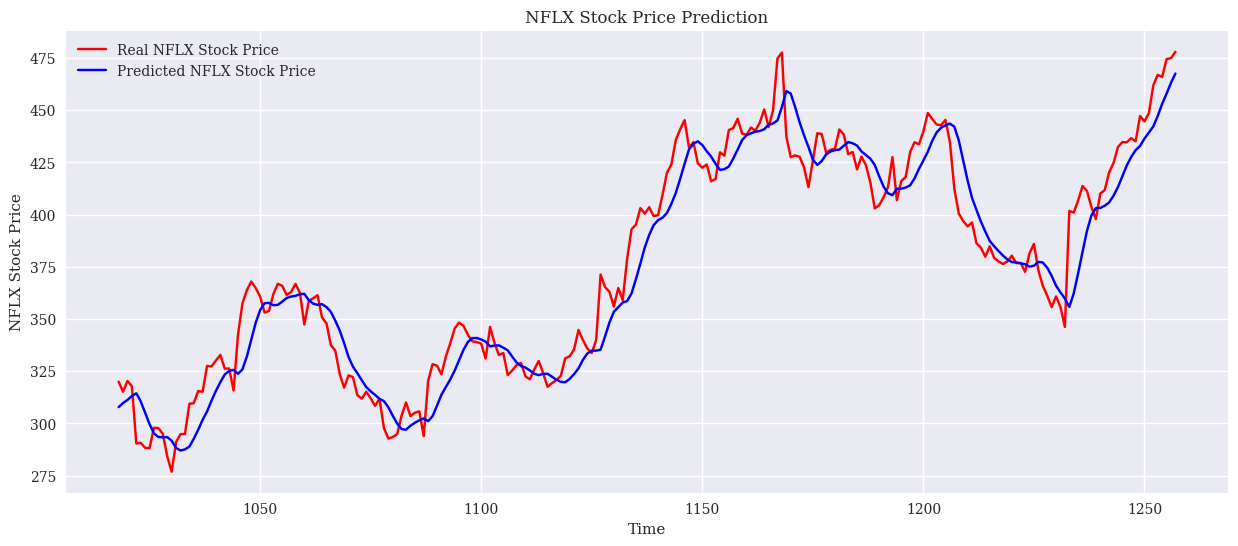

In [13]:
figure, axes = plt.subplots(figsize=(15, 6))
y_test = y_test[:, 0].reshape(test_size, 1)


axes.plot(df_nflx[len(df_nflx)-len(y_test):].index, y_test, color = 'red', label = 'Real NFLX Stock Price')
axes.plot(df_nflx[len(df_nflx)-len(y_test):].index, results, color = 'blue', label = 'Predicted NFLX Stock Price')


plt.title('NFLX Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NFLX Stock Price')
plt.legend()
plt.show()